In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import keras
import cv2
import time

In [2]:
import os, random

print('[INFO] RANDOMLY SELECTING IMAGE')
rand_select_img = []
rand_select_label = []

i = 0

aonan_data_path = os.listdir('datasets_VGG/aonan')
elf_data_path = os.listdir('datasets_VGG/elf')

while i <= 15 :
    rand_select_img.append(f'datasets_VGG/aonan/{random.choice(aonan_data_path)}')
    rand_select_label.append('aonan')
    rand_select_img.append(f'datasets_VGG/elf/{random.choice(elf_data_path)}')
    rand_select_label.append('elf')
    i+=1

unknown_data_path = os.listdir('datasets_VGG/unknown')

i = 0
while i <= 25 : 
    rand_select_img.append(f'datasets_VGG/unknown/{random.choice(unknown_data_path)}')
    rand_select_label.append('unknown')
    i+=1
print(f'Image selected : {len(rand_select_img)} images')
print(f'Total label : {len(rand_select_img)} labels ')

[INFO] RANDOMLY SELECTING IMAGE
Image selected : 58 images
Total label : 58 labels 


In [6]:
prob_model = load_model('./model/model_2025-09-03_1756862707.101024.tf')

In [10]:
name = ['aonan','elf','unknown']

In [5]:
sample_set = []
for img in rand_select_img :
    sample = cv2.imread(img)
    sample_set.append(sample)


In [8]:
def sample_process(sample) :
    sample_reshape = cv2.resize(sample,dsize=(224,224))
    sample = tf.convert_to_tensor(sample_reshape, dtype=tf.float32)
    sample = tf.expand_dims(sample, 0)
    return sample

In [7]:
sample_set_processed = []
for sample in sample_set :
    sample_e = sample_process(sample)
    sample_set_processed.append(sample_e)

In [8]:
sample_set_processed[0].shape

TensorShape([1, 224, 224, 3])

In [25]:
def decode_prediction(predictions, label):
    confidence = predictions[0][predictions[0].argmax()] * 100
    print(predictions[0][predictions[0].argmax()])
    if confidence > 80 : 
        return label[predictions[0].argmax()]
    else :
        return 'unknown'

In [26]:
pred_label = []
for sample in sample_set_processed :
    predictions = prob_model.predict(sample)
    pred_label.append(decode_prediction(predictions, name))
print(pred_label)

1/1 [==============================] - 0s 18ms/step
0.930879
1/1 [==============================] - 0s 14ms/step
0.89863724
1/1 [==============================] - 0s 16ms/step
0.91940814
1/1 [==============================] - 0s 17ms/step
0.89580745
1/1 [==============================] - 0s 13ms/step
0.927228
1/1 [==============================] - 0s 21ms/step
0.82071227
1/1 [==============================] - 0s 23ms/step
0.9383903
1/1 [==============================] - 0s 23ms/step
0.92442816
1/1 [==============================] - 0s 23ms/step
0.9328688
1/1 [==============================] - 0s 19ms/step
0.8813955
1/1 [==============================] - 0s 18ms/step
0.9181856
1/1 [==============================] - 0s 18ms/step
0.8700076
1/1 [==============================] - 0s 8ms/step
0.90420294
1/1 [==============================] - 0s 24ms/step
0.84927994
1/1 [==============================] - 0s 19ms/step
0.93259436
1/1 [==============================] - 0s 17ms/step
0.9018022
1/1

In [12]:
from sklearn import metrics
import matplotlib.pyplot as plt

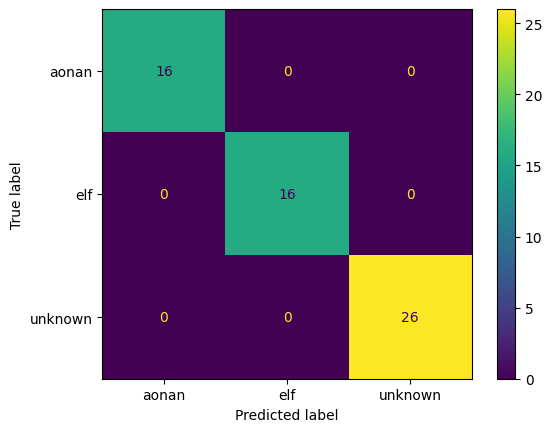

In [27]:
confusion_matrix = metrics.confusion_matrix(rand_select_label, pred_label)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=name)
cm_display.plot()
plt.show()

### Real-Time recognition testing

In [2]:
import cv2, queue, threading, time

##### Custom-made video capture for using with CCTV

In [4]:
class VideoCapture:

  def __init__(self, name):
    self.cap = cv2.VideoCapture(name)
    self.q = queue.Queue()
    t = threading.Thread(target=self._reader)
    t.daemon = True
    t.start()

  def _reader(self):
    while True:
      ret, frame = self.cap.read()
      if not ret:
        break
      if not self.q.empty():
        try:
          self.q.get_nowait()
        except queue.Empty:
          pass
      self.q.put(frame)

  def read(self):
    return self.q.get()
  
  def release(self):
    self.cap.release()


In [12]:
cap = VideoCapture(0)
font = cv2.FONT_HERSHEY_SIMPLEX
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')

color = (0, 255, 0)
fontsize = 2

while(True):
    img = cap.read()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(
        gray,     
        scaleFactor=1.2,
        minNeighbors=5,     
        minSize=(10, 10)
    )
    for (x,y,w,h) in faces:
        cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)
        predictions = prob_model.predict(sample_process(img[y:y+h,x:x+w]), verbose=0)
        id = predictions[0].argmax()
        confidence = predictions[0][predictions[0].argmax()] * 100
        if (confidence > 75):
            id = name[id]
            cv2.putText(
                    img, 
                    str(id), 
                    (x+5,y-5), 
                    font, 
                    1, 
                    (255,255,255), 
                    2
                   )
            cv2.putText(
                    img, 
                    str(confidence), 
                    (x+5,y+h-5), 
                    font, 
                    1, 
                    (255,255,0), 
                    1
                   )  
        else:
            id = "unknown"
            cv2.putText(
                    img, 
                    str(id), 
                    (x+5,y-5), 
                    font, 
                    1, 
                    (255,255,255), 
                    2
                   )
        
    cv2.imshow('camera',img)
    k = cv2.waitKey(10) & 0xff
    if k == 27:
        break
print("\n [INFO] Exiting Program and cleanup stuff")
cap.release()
cv2.destroyAllWindows()


 [INFO] Exiting Program and cleanup stuff


In [ ]:
pip install windows-capture-device-list

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for windows-capture-device-list: filename=windows_capture_device_list-1.1.0-py3-none-any.whl size=3555 sha256=460a2e28792d40833188de1ed7b5a216908f97e96dc5e958e6d64120d95fea77
  Stored in directory: /home/phanxv/.var/app/com.visualstudio.code/cache/pip/wheels/80/04/d8/3d85b7688d48be2d1f975a8ba6da1569a92dd1622d4e1bfec1
Successfully built windows-capture-device-list
Note: you may need to restart the kernel to use updated packages.
